In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib


pd.set_option('display.max_rows', 1000000)
pd.set_option('display.max_columns', 1000000)

## Reading data

In [2]:
df_transactions = pd.read_csv('transactions.csv')
df_demographics = pd.read_csv('demographics.csv')
df_products = pd.read_csv('products.csv')
df_promotions = pd.read_csv('time_on_app.csv')
# df_promotions = pd.read_csv('promotions.csv')
df_campaigns = pd.read_csv('campaigns.csv')

In [3]:
df_transactions.head()

,DAY,WEEK_NO,HOUSEHOLD_KEY,PRODUCT_ID,SALES_VALUE,QUANTITY,DISCOUNT
0,1,1,98,482570739,3.00,2.0,-0.08
1,1,1,98,1312103697,0.39,1.0,0.00
2,1,1,98,6362867950,1.15,4.0,0.00
3,1,1,98,7507761482,1.25,1.0,-0.34
4,1,1,212,433276498,2.69,1.0,0.00


In [4]:
df_promotions.head()

,HOUSEHOLD_KEY,WEEK_NO,time_spent_on_app
0,1,8,65.047572
1,1,10,72.320716
2,1,13,76.228637
3,1,14,67.906754
4,1,15,70.564681


# Adding time information: month, weekday, season

In [5]:
spring_summer_products = df_products[df_products['COMMODITY_DESC']=='SPRING/SUMMER SEASONAL']['PRODUCT_ID'].to_list()
fall_winter_products = df_products[df_products['COMMODITY_DESC']=='FALL AND WINTER SEASONAL']['PRODUCT_ID'].to_list()
christmas_products = df_products[df_products['COMMODITY_DESC'].str.contains('CHRISTMAS')]['PRODUCT_ID'].to_list()

spring_summer = df_transactions[df_transactions['PRODUCT_ID'].isin(spring_summer_products)]
fall_winter = df_transactions[df_transactions['PRODUCT_ID'].isin(fall_winter_products)]
christmas = df_transactions[df_transactions['PRODUCT_ID'].isin(christmas_products)]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


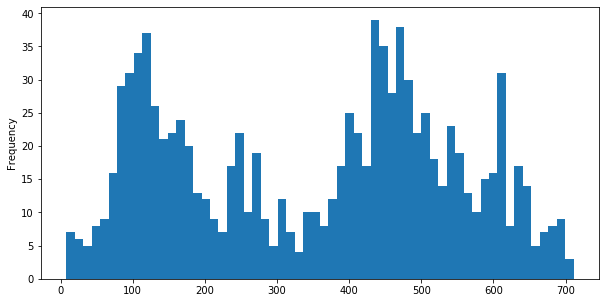

In [6]:
spring_summer['DAY'].plot('hist', bins=60, figsize=(10,5))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


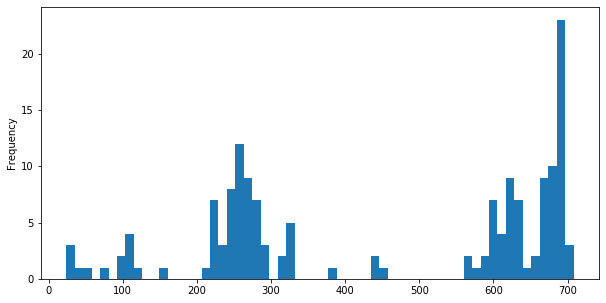

In [7]:
fall_winter['DAY'].plot('hist', bins=60, figsize=(10,5))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


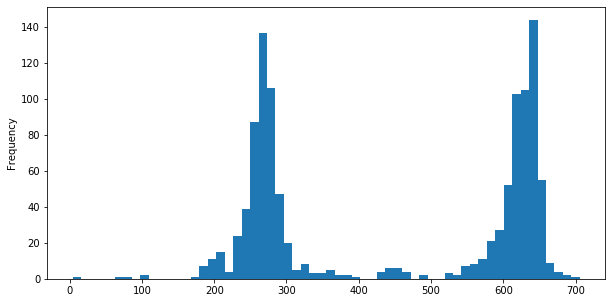

In [8]:
christmas['DAY'].plot('hist', bins=60, figsize=(10,5))

In [9]:
def add_month_names(day):
    day_number = day%340
    if day_number<10:
        return 'February', 2
    elif day_number<40:
        return 'March', 3
    elif day_number<70:
        return 'April', 4
    elif day_number<100:
        return 'May', 5
    elif day_number<130:
        return 'June', 6
    elif day_number<160:
        return 'July', 7
    elif day_number<190:
        return 'August', 8
    elif day_number<220:
        return 'September', 9
    elif day_number<250:
        return 'October', 10
    elif day_number<280:
        return 'November', 11
    elif day_number<310:
        return 'December', 12
    elif day_number<340:
        return 'January', 1

df_transactions['month'], df_transactions['month_num'] = zip(*df_transactions['DAY'].apply(add_month_names))


def add_week_day_names(day):
    day_number = day%7
    if day_number==1:
        return 'Tuesday', day_number+1
    elif day_number==2:
        return 'Wednesday', day_number+1
    elif day_number==3:
        return 'Thursday', day_number+1
    elif day_number==4:
        return 'Friday', day_number+1
    elif day_number==5:
        return 'Saturday', day_number+1
    elif day_number==6:
        return 'Sunday', day_number+1
    elif day_number==0:
        return 'Monday', day_number+1
    
df_transactions['weekday'],df_transactions['weekday_num'] = zip(*df_transactions['DAY'].apply(add_week_day_names))


def get_season(month):
    if month == 'December' or month == 'January' or month == 'February':
        return 'winter'
    elif month == 'March' or month == 'April' or month == 'May':
        return 'spring'
    elif month == 'June' or month == 'July' or month == 'August':
        return 'summer'
    elif month == 'September' or month == 'October' or month == 'November':
        return 'fall'
    
df_transactions['season'] = df_transactions['month'].apply(get_season)



In [10]:
week_month_lookup = df_transactions[['DAY','WEEK_NO','month_num']].drop_duplicates().reset_index().drop('index',axis=1)
week_month_lookup.drop('DAY', axis=1, inplace=True)
week_month_lookup.drop_duplicates(subset=['WEEK_NO'], keep="first", inplace=True)

print(week_month_lookup.shape)
week_month_lookup.head(10)

(102, 2)


,WEEK_NO,month_num
4,1,2
11,2,3
18,3,3
25,4,3
32,5,3
39,6,4
46,7,4
53,8,4
60,9,4
67,10,4


## 2 merge with product table

In [11]:
things_families_buy = df_transactions[['HOUSEHOLD_KEY','PRODUCT_ID']].merge(df_products, on='PRODUCT_ID', how='left')

things_families_buy = things_families_buy[['HOUSEHOLD_KEY','DEPARTMENT','COMMODITY_DESC']]
things_families_buy.sort_values(by='HOUSEHOLD_KEY').head()

things_families_buy.head()



,HOUSEHOLD_KEY,DEPARTMENT,COMMODITY_DESC
0,98,GROCERY,COOKIES/CONES
1,98,PRODUCE,TROPICAL FRUIT
2,98,GROCERY,BAG SNACKS
3,98,GROCERY,BAKED SWEET GOODS
4,212,GROCERY,CONDIMENTS/SAUCES


In [12]:
most_popular_department = things_families_buy.drop('HOUSEHOLD_KEY', axis=1).reset_index().drop('index',axis=1)
most_popular_department = most_popular_department.groupby('DEPARTMENT').size().reset_index()
most_popular_department.rename(columns={0:'count'}, inplace=True)
most_popular_department = most_popular_department.sort_values('count', ascending=False)
most_popular_department_list = most_popular_department.head()['DEPARTMENT'].tolist()
most_popular_department_list

['GROCERY', 'PRODUCE', 'DRUG GM', 'MEAT-PCKGD', 'MEAT']

In [13]:
most_popular_commodity = things_families_buy.drop('HOUSEHOLD_KEY', axis=1).reset_index().drop('index',axis=1)
most_popular_commodity = most_popular_commodity.groupby('COMMODITY_DESC').size().reset_index()
most_popular_commodity.rename(columns={0:'count'}, inplace=True)
most_popular_commodity = most_popular_commodity.sort_values('count', ascending=False)
most_popular_commodity_list = most_popular_commodity.head()['COMMODITY_DESC'].tolist()
most_popular_commodity_list

['FLUID MILK PRODUCTS',
 'SOFT DRINKS',
 'BAKED BREAD/BUNS/ROLLS',
 'CHEESE',
 'BAG SNACKS']

In [14]:
most_popular_department_per_family = things_families_buy.groupby(['HOUSEHOLD_KEY','DEPARTMENT']).size().reset_index()
most_popular_department_per_family.rename(columns={0:'count'}, inplace=True)
most_popular_department_per_family_reduced = most_popular_department_per_family[most_popular_department_per_family['DEPARTMENT'].isin(most_popular_department_list)]

most_popular_department_per_family_reduced.head()


,HOUSEHOLD_KEY,DEPARTMENT,count
1,1,DRUG GM,120
3,1,GROCERY,856
4,1,MEAT,4
5,1,MEAT-PCKGD,91
10,1,PRODUCE,152


In [15]:
popular_department_table = most_popular_department_per_family_reduced.pivot(index='HOUSEHOLD_KEY', columns = 'DEPARTMENT', values='count')
popular_department_table.columns.name = None

popular_department_table.fillna(0, inplace=True)
popular_department_table = popular_department_table.reset_index()

popular_department_table.head()


,HOUSEHOLD_KEY,DRUG GM,GROCERY,MEAT,MEAT-PCKGD,PRODUCE
0,1,120.0,856.0,4.0,91.0,152.0
1,7,115.0,569.0,35.0,23.0,117.0
2,8,148.0,844.0,52.0,64.0,147.0
3,13,290.0,1059.0,1.0,74.0,109.0
4,16,31.0,303.0,15.0,17.0,42.0


In [16]:
most_popular_commodity_per_family = things_families_buy.groupby(['HOUSEHOLD_KEY','COMMODITY_DESC']).size().reset_index()
most_popular_commodity_per_family.rename(columns={0:'count'}, inplace=True)
most_popular_commodity_per_family_reduced = most_popular_commodity_per_family[most_popular_commodity_per_family['COMMODITY_DESC'].isin(most_popular_commodity_list)]

most_popular_commodity_per_family_reduced.head()


,HOUSEHOLD_KEY,COMMODITY_DESC,count
4,1,BAG SNACKS,43
5,1,BAKED BREAD/BUNS/ROLLS,61
21,1,CHEESE,38
55,1,FLUID MILK PRODUCTS,40
113,1,SOFT DRINKS,29


In [17]:
popular_commodity_table = most_popular_commodity_per_family_reduced.pivot(index='HOUSEHOLD_KEY', columns = 'COMMODITY_DESC', values='count')
popular_commodity_table.columns.name = None

popular_commodity_table.fillna(0, inplace=True)
popular_commodity_table = popular_commodity_table.reset_index()

popular_commodity_table.head()


,HOUSEHOLD_KEY,BAG SNACKS,BAKED BREAD/BUNS/ROLLS,CHEESE,FLUID MILK PRODUCTS,SOFT DRINKS
0,1,43.0,61.0,38.0,40.0,29.0
1,7,18.0,27.0,23.0,23.0,12.0
2,8,18.0,44.0,42.0,42.0,29.0
3,13,31.0,35.0,43.0,102.0,33.0
4,16,10.0,68.0,5.0,45.0,5.0


## aggregate by day

In [18]:
daily_transactions = df_transactions.groupby(["HOUSEHOLD_KEY", "DAY",'WEEK_NO'])[["SALES_VALUE",'QUANTITY','DISCOUNT']].sum().reset_index()
daily_transactions.head()


,HOUSEHOLD_KEY,DAY,WEEK_NO,SALES_VALUE,QUANTITY,DISCOUNT
0,1,51,8,78.66,34.0,-16.54
1,1,67,10,41.10,14.0,-8.59
2,1,88,13,26.90,13.0,-6.72
3,1,94,14,63.43,32.0,-11.58
4,1,101,15,53.45,20.0,-16.42


In [19]:
daily_transactions['last_shopping_day'] = daily_transactions['DAY'].shift(1)
daily_transactions['days_since_shopping'] = daily_transactions['DAY']-daily_transactions['last_shopping_day']
daily_transactions = daily_transactions[['HOUSEHOLD_KEY','DAY','WEEK_NO','days_since_shopping']]
daily_transactions.head()

,HOUSEHOLD_KEY,DAY,WEEK_NO,days_since_shopping
0,1,51,8,NaN
1,1,67,10,16.0
2,1,88,13,21.0
3,1,94,14,6.0
4,1,101,15,7.0


In [20]:
# WE ARE GOING TO NEED IT IN WEEK FORMAT

# keep last
# previous_visit_day = daily_transactions.drop_duplicates(subset=['HOUSEHOLD_KEY','WEEK_NO'], keep="last")
# previous_visit_day.drop('DAY', axis=1, inplace=True)
# previous_visit_day.head()

# keep average
previous_visit_day = daily_transactions.groupby(['HOUSEHOLD_KEY','WEEK_NO']).mean().reset_index()
previous_visit_day.drop('DAY', axis=1, inplace=True)
previous_visit_day.head()


,HOUSEHOLD_KEY,WEEK_NO,days_since_shopping
0,1,8,NaN
1,1,10,16.0
2,1,13,21.0
3,1,14,6.0
4,1,15,7.0


In [21]:
df_transactions = df_transactions.merge(previous_visit_day, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
df_transactions.head()

,DAY,WEEK_NO,HOUSEHOLD_KEY,PRODUCT_ID,SALES_VALUE,QUANTITY,DISCOUNT,month,month_num,weekday,weekday_num,season,days_since_shopping
0,1,1,98,482570739,3.00,2.0,-0.08,February,2,Tuesday,2,winter,-351.0
1,1,1,98,1312103697,0.39,1.0,0.00,February,2,Tuesday,2,winter,-351.0
2,1,1,98,6362867950,1.15,4.0,0.00,February,2,Tuesday,2,winter,-351.0
3,1,1,98,7507761482,1.25,1.0,-0.34,February,2,Tuesday,2,winter,-351.0
4,1,1,212,433276498,2.69,1.0,0.00,February,2,Tuesday,2,winter,-709.0


## aggregate to weekly

In [22]:
transactions_weekly_aggregated = df_transactions.groupby(["HOUSEHOLD_KEY", "WEEK_NO"])[["SALES_VALUE",'QUANTITY','DISCOUNT']].sum().reset_index()
transactions_weekly_aggregated = transactions_weekly_aggregated.sort_values(by=['HOUSEHOLD_KEY','WEEK_NO']).reset_index().drop('index', axis=1)
transactions_weekly_aggregated.head()

,HOUSEHOLD_KEY,WEEK_NO,SALES_VALUE,QUANTITY,DISCOUNT
0,1,8,78.66,34.0,-16.54
1,1,10,41.10,14.0,-8.59
2,1,13,26.90,13.0,-6.72
3,1,14,63.43,32.0,-11.58
4,1,15,53.45,20.0,-16.42


In [23]:
transactions_weekly_aggregated['prev_amount'] = transactions_weekly_aggregated['SALES_VALUE'].shift(1)

In [24]:
transactions_weekly_aggregated.head()

,HOUSEHOLD_KEY,WEEK_NO,SALES_VALUE,QUANTITY,DISCOUNT,prev_amount
0,1,8,78.66,34.0,-16.54,NaN
1,1,10,41.10,14.0,-8.59,78.66
2,1,13,26.90,13.0,-6.72,41.10
3,1,14,63.43,32.0,-11.58,26.90
4,1,15,53.45,20.0,-16.42,63.43


In [ ]:
# # we need to generate the fake variable here and save it before the training

# from random import randint
# import numpy as np


# #time spent on the app's discount section
# data = transactions_weekly_aggregated.copy()

# noise = np.random.normal(0,1,data.shape[0])
# noise

# data['time_spent_on_app'] = (data['SALES_VALUE']/10 - data['prev_amount'] + 3*noise + 400) *0.2
# data['time_spent_on_app'] = data['time_spent_on_app'].apply(lambda x: x+100 if x<0 else x)
# min_val = int(data['time_spent_on_app'].min())
# max_val = int(data['time_spent_on_app'].max())
# data['time_spent_on_app'] = data['time_spent_on_app'].apply(lambda x: x+100 if x<(randint(min_val,max_val)*0.3) else x)
# data['time_spent_on_app'] = data.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['time_spent_on_app'].shift(-1)

# df_promotions = data[['HOUSEHOLD_KEY','WEEK_NO','time_spent_on_app']]
# df_promotions.to_csv('time_on_app.csv', index=False)
# df_promotions.head()


In [ ]:
# TODO: new table with all households and all weeks for aggregated weekly transaction

## Preliminary prediction

In [63]:
# Merge everything together

a = transactions_weekly_aggregated.merge(df_demographics, on='HOUSEHOLD_KEY', how='left')
b = a.merge(df_campaigns, on='WEEK_NO', how='left')
c = b.merge(df_promotions, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
d = c.merge(week_month_lookup, on='WEEK_NO', how='left')
e = d.merge(popular_department_table, on='HOUSEHOLD_KEY', how='left')
f = e.merge(popular_commodity_table, on='HOUSEHOLD_KEY', how='left')
g = f.merge(previous_visit_day, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
training_data = g.copy()
training_data.head()

,HOUSEHOLD_KEY,WEEK_NO,SALES_VALUE,QUANTITY,DISCOUNT,prev_amount,AGE_MEAN,HOUSEHOLD_SIZE,NUM_ADULTS,MARITAL_STATUS,INCOME_MEAN,NUM_CAMPAIGNS,FUEL_PRICE_DIFF,time_spent_on_app,month_num,DRUG GM,GROCERY,MEAT,MEAT-PCKGD,PRODUCE,BAG SNACKS,BAKED BREAD/BUNS/ROLLS,CHEESE,FLUID MILK PRODUCTS,SOFT DRINKS,days_since_shopping
0,1,8,78.66,34.0,-16.54,NaN,65,2,2,1.0,42000,0,-3,65.047572,4,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,NaN
1,1,10,41.10,14.0,-8.59,78.66,65,2,2,1.0,42000,0,0,72.320716,4,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,16.0
2,1,13,26.90,13.0,-6.72,41.10,65,2,2,1.0,42000,0,-4,76.228637,5,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,21.0
3,1,14,63.43,32.0,-11.58,26.90,65,2,2,1.0,42000,0,-4,67.906754,5,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,6.0
4,1,15,53.45,20.0,-16.42,63.43,65,2,2,1.0,42000,0,0,70.564681,6,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,7.0


In [64]:
# causes leakage
# d['time_spent_on_app'] = d.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['time_spent_on_app'].shift(-1)


In [65]:
training_data.head()

,HOUSEHOLD_KEY,WEEK_NO,SALES_VALUE,QUANTITY,DISCOUNT,prev_amount,AGE_MEAN,HOUSEHOLD_SIZE,NUM_ADULTS,MARITAL_STATUS,INCOME_MEAN,NUM_CAMPAIGNS,FUEL_PRICE_DIFF,time_spent_on_app,month_num,DRUG GM,GROCERY,MEAT,MEAT-PCKGD,PRODUCE,BAG SNACKS,BAKED BREAD/BUNS/ROLLS,CHEESE,FLUID MILK PRODUCTS,SOFT DRINKS,days_since_shopping
0,1,8,78.66,34.0,-16.54,NaN,65,2,2,1.0,42000,0,-3,65.047572,4,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,NaN
1,1,10,41.10,14.0,-8.59,78.66,65,2,2,1.0,42000,0,0,72.320716,4,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,16.0
2,1,13,26.90,13.0,-6.72,41.10,65,2,2,1.0,42000,0,-4,76.228637,5,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,21.0
3,1,14,63.43,32.0,-11.58,26.90,65,2,2,1.0,42000,0,-4,67.906754,5,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,6.0
4,1,15,53.45,20.0,-16.42,63.43,65,2,2,1.0,42000,0,0,70.564681,6,120.0,856.0,4.0,91.0,152.0,43.0,61.0,38.0,40.0,29.0,7.0


In [66]:
training_data.dropna(inplace=True)
training_data.columns

Index(['HOUSEHOLD_KEY', 'WEEK_NO', 'SALES_VALUE', 'QUANTITY', 'DISCOUNT',
       'prev_amount', 'AGE_MEAN', 'HOUSEHOLD_SIZE', 'NUM_ADULTS',
       'MARITAL_STATUS', 'INCOME_MEAN', 'NUM_CAMPAIGNS', 'FUEL_PRICE_DIFF',
       'time_spent_on_app', 'month_num', 'DRUG GM', 'GROCERY', 'MEAT',
       'MEAT-PCKGD', 'PRODUCE', 'BAG SNACKS', 'BAKED BREAD/BUNS/ROLLS',
       'CHEESE', 'FLUID MILK PRODUCTS', 'SOFT DRINKS', 'days_since_shopping'],
      dtype='object')

In [67]:
columns_to_predict_on = ['QUANTITY', 'DISCOUNT',
       'prev_amount', 'AGE_MEAN', 'HOUSEHOLD_SIZE', 'NUM_ADULTS',
       'MARITAL_STATUS', 'INCOME_MEAN', 'NUM_CAMPAIGNS', 'FUEL_PRICE_DIFF',
       'time_spent_on_app', 'month_num', 'DRUG GM', 'GROCERY', 'MEAT',
       'MEAT-PCKGD', 'PRODUCE', 'BAG SNACKS', 'BAKED BREAD/BUNS/ROLLS',
       'CHEESE', 'FLUID MILK PRODUCTS', 'SOFT DRINKS', 'days_since_shopping']

# columns_to_predict_on = ['QUANTITY', 'DISCOUNT',
#        'AGE_MEAN', 'HOUSEHOLD_SIZE', 'NUM_ADULTS', 'MARITAL_STATUS',
#        'INCOME_MEAN', 'NUM_CAMPAIGNS', 'FUEL_PRICE_DIFF', 'month_num', 'TIME_IN_APP']



In [68]:
X = training_data[columns_to_predict_on]
X = pd.get_dummies(X)
print(X.shape)

y = training_data['SALES_VALUE']

# option 1 - temporal split
total_data = X.shape[0]
training_amount = int(total_data*0.8)

X_train = X[:training_amount]
y_train = y[:training_amount]
X_test = X[training_amount:]
y_test = y[training_amount:]

(31560, 23)


In [69]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {'max_depth':5, 'eta':0.7, 'booster':'gbtree', 'subsample':0.5,
         'objective':'reg:squarederror','eval_metric':'rmse'}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 15
bst = xgb.train(param, dtrain, num_round, evallist)


[0]	eval-rmse:37.945	train-rmse:36.1572
[1]	eval-rmse:16.2011	train-rmse:15.7305


/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[2]	eval-rmse:11.7135	train-rmse:11.3279
[3]	eval-rmse:11.0828	train-rmse:9.69309
[4]	eval-rmse:11.0485	train-rmse:9.51312
[5]	eval-rmse:10.9177	train-rmse:8.61701
[6]	eval-rmse:10.6353	train-rmse:8.36819
[7]	eval-rmse:10.6559	train-rmse:8.30866
[8]	eval-rmse:10.2447	train-rmse:8.12734
[9]	eval-rmse:10.2195	train-rmse:8.07637
[10]	eval-rmse:10.2089	train-rmse:8.00145
[11]	eval-rmse:10.0689	train-rmse:7.94381
[12]	eval-rmse:10.7544	train-rmse:7.9283
[13]	eval-rmse:10.2605	train-rmse:7.75059
[14]	eval-rmse:10.255	train-rmse:7.59609


In [70]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

preds = bst.predict(dtest)
mae = mean_absolute_error(y_test, preds)
print('mean absolute error: ' + str(mae))

mse = mean_squared_error(y_test, preds)
rmse = math.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, preds)
print('mean squared error: ' + str(mse))
print('root mean squared error: ' + str(rmse))
print('mean absolute percentage error: ' + str(rmse))

r2 = r2_score(y_test, preds) 
print('R2: ' + str(r2))

mean absolute error: 6.379904283306294
mean squared error: 105.16530023989712
root mean squared error: 10.255013419781426
mean absolute percentage error: 10.255013419781426
R2: 0.9814649928184619


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


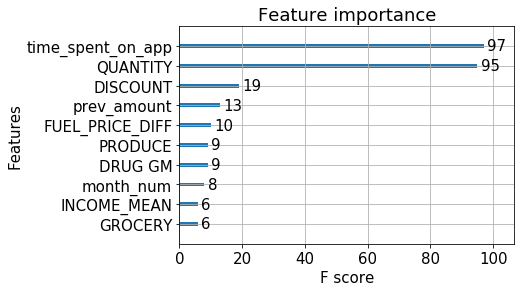

In [71]:
matplotlib.rcParams.update({'font.size': 15})
xgb.plot_importance(bst,max_num_features=10)

In [72]:
# fix leakage problem
#1
training_data['QUANTITY'] = training_data.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['QUANTITY'].shift(1)

# #2
training_data['DISCOUNT'] = training_data.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['DISCOUNT'].shift(1)


training_data['time_spent_on_app'] = training_data.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['time_spent_on_app'].shift(1)


# d['NUM_COUPONS'] = d.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['NUM_COUPONS'].shift(1)


training_data.dropna(inplace=True)
training_data.columns

Index(['HOUSEHOLD_KEY', 'WEEK_NO', 'SALES_VALUE', 'QUANTITY', 'DISCOUNT',
       'prev_amount', 'AGE_MEAN', 'HOUSEHOLD_SIZE', 'NUM_ADULTS',
       'MARITAL_STATUS', 'INCOME_MEAN', 'NUM_CAMPAIGNS', 'FUEL_PRICE_DIFF',
       'time_spent_on_app', 'month_num', 'DRUG GM', 'GROCERY', 'MEAT',
       'MEAT-PCKGD', 'PRODUCE', 'BAG SNACKS', 'BAKED BREAD/BUNS/ROLLS',
       'CHEESE', 'FLUID MILK PRODUCTS', 'SOFT DRINKS', 'days_since_shopping'],
      dtype='object')

In [73]:
X = training_data[columns_to_predict_on]
X = pd.get_dummies(X)
print(X.shape)

y = training_data['SALES_VALUE']

# option 1 - temporal split
total_data = X.shape[0]
training_amount = int(total_data*0.8)

X_train = X[:training_amount]
y_train = y[:training_amount]
X_test = X[training_amount:]
y_test = y[training_amount:]

(31103, 23)


In [74]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {'max_depth':5, 'eta':0.7, 'booster':'gbtree', 'subsample':0.5,
         'objective':'reg:squarederror','eval_metric':'rmse'}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 15
bst = xgb.train(param, dtrain, num_round, evallist)


[0]	eval-rmse:69.083	train-rmse:65.8996
[1]	eval-rmse:63.9918	train-rmse:58.0066


/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[2]	eval-rmse:63.6819	train-rmse:55.8955
[3]	eval-rmse:63.0162	train-rmse:54.4584
[4]	eval-rmse:61.4495	train-rmse:52.3232
[5]	eval-rmse:60.7497	train-rmse:51.56
[6]	eval-rmse:60.3777	train-rmse:50.8241
[7]	eval-rmse:57.8776	train-rmse:48.1713
[8]	eval-rmse:54.1292	train-rmse:44.9177
[9]	eval-rmse:53.3761	train-rmse:43.6051
[10]	eval-rmse:52.8041	train-rmse:42.7762
[11]	eval-rmse:51.3358	train-rmse:41.4178
[12]	eval-rmse:49.8526	train-rmse:40.0968
[13]	eval-rmse:49.7898	train-rmse:39.4751
[14]	eval-rmse:49.2647	train-rmse:38.4568


In [75]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

preds = bst.predict(dtest)
mae = mean_absolute_error(y_test, preds)
print('mean absolute error: ' + str(mae))

mse = mean_squared_error(y_test, preds)
rmse = math.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, preds)
print('mean squared error: ' + str(mse))
print('root mean squared error: ' + str(rmse))
print('mean absolute percentage error: ' + str(rmse))

r2 = r2_score(y_test, preds) 
print('R2: ' + str(r2))

mean absolute error: 35.371222509837594
mean squared error: 2427.0110956483904
root mean squared error: 49.264704359697426
mean absolute percentage error: 49.264704359697426
R2: 0.5702811917792205


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


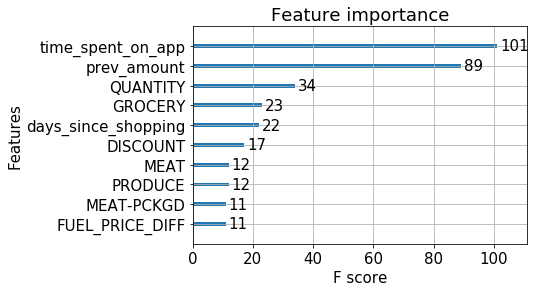

In [76]:
matplotlib.rcParams.update({'font.size': 15})
xgb.plot_importance(bst,max_num_features=10)